# Ensemble of task2x Regression Models

In [38]:
# Try by using floor before weighting

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import torch
import torch.nn as nn
from transformers import LongformerModel, LongformerTokenizer
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import pickle
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

/data01/alocaputo/miniconda3/envs/icdar2025/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


## Load Model Architecture and Helper Functions

In [2]:
# Model definition
class SingleHeadLongformerModel(nn.Module):
    def __init__(self):
        super(SingleHeadLongformerModel, self).__init__()
        
        self.longformer = LongformerModel.from_pretrained('allenai/longformer-base-4096')
        
        # Regression head - outputs a single continuous value
        self.decade_regressor = nn.Sequential(
            nn.Linear(self.longformer.config.hidden_size, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 1)
        )
    
    def forward(self, input_ids, attention_mask):
        outputs = self.longformer(
            input_ids=input_ids, 
            attention_mask=attention_mask
        )
        
        pooled_output = outputs.last_hidden_state[:, 0, :]
        decade_prediction = self.decade_regressor(pooled_output).squeeze(-1)
        
        return decade_prediction

In [3]:
# Helper functions
def convert_to_absolute_decade(century, decade):
    """Convert century (0-4) and decade (0-9) to absolute decade (0-42)"""
    return century * 10 + decade

def mean_avg_error(y_true, y_pred):
    """Calculate Mean Absolute Error between true and predicted values"""
    return np.mean(np.abs(y_true - y_pred))

class FileBasedSingleTaskDataset(Dataset):
    def __init__(self, file_paths, path, century_labels, decade_labels, tokenizer, max_length=1536):
        self.file_paths = file_paths
        self.path = path
        self.century_labels = century_labels
        self.decade_labels = decade_labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        century = self.century_labels[idx]
        decade = self.decade_labels[idx]
        
        # Convert to absolute decade label
        absolute_decade = convert_to_absolute_decade(century, decade)
        
        with open(os.path.join(self.path, file_path), 'r', encoding='utf-8') as f:
            text = f.read()
        
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        encoding = {key: val.squeeze(0) for key, val in encoding.items()}
        encoding['decade_labels'] = torch.tensor(absolute_decade, dtype=torch.long)
        
        return encoding

## Load Data

In [40]:
# Load data
texts_path = './data/Task2/texts'

train_path = os.path.join(texts_path, 'train')
valid_path = os.path.join(texts_path, 'valid')

# Task 2.1
train21 = pd.read_csv('./data/Task2/task2.1/train.csv')
valid21 = pd.read_csv('./data/Task2/task2.1/valid.csv')

train21.rename(columns={'label': 'century'}, inplace=True)
train21['file_name'] = train21['id']
train21['id'] = train21.id.str.replace('train_text', '').str.replace('.txt', '').astype(int)
train21.set_index('id', inplace=True)

valid21.rename(columns={'label': 'century'}, inplace=True)
valid21['file_name'] = valid21['id']
valid21['id'] = valid21.id.str.replace('valid_text', '').str.replace('.txt', '').astype(int)
valid21.set_index('id', inplace=True)

# Task 2.2
train22 = pd.read_csv('./data/Task2/task2.2/train.csv')
valid22 = pd.read_csv('./data/Task2/task2.2/valid.csv')

train22.rename(columns={'label': 'century'}, inplace=True)
train22['file_name'] = train22['id']
train22['id'] = train22.id.str.replace('train_text', '').str.replace('.txt', '').astype(int)
train22.set_index('id', inplace=True)

valid22.rename(columns={'label': 'century'}, inplace=True)
valid22['file_name'] = valid22['id']
valid22['id'] = valid22.id.str.replace('valid_text', '').str.replace('.txt', '').astype(int)
valid22.set_index('id', inplace=True)

In [42]:
# Load blacklist
with open('blacklist.pkl', 'rb') as f:
    blacklist = pickle.load(f)

blacklist_train = blacklist['train']
blacklist_valid = blacklist['valid']

X_train_21 = [] # file names (.txt)
y_train_21 = [] 
X_valid_21 = [] # file names (.txt)
y_valid_21 = []
X_train_22 = [] # file names (.txt)
y_train_22 = []
X_valid_22 = [] # file names (.txt)
y_valid_22 = []

# Process Task 2.1 data
for idx, row in train21.iterrows():
    file_name = row.file_name
    century = row.century

    with open(os.path.join(texts_path, file_name), 'r') as file:
        text = file.read()
    if 'gutenberg' in text.lower() and 'project' in text.lower():
        continue

    X_train_21.append(file_name)
    y_train_21.append(century-1)

for idx, row in valid21.iterrows():
    file_name = row.file_name
    century = row.century

    with open(os.path.join(texts_path, file_name), 'r') as file:
        text = file.read()
    if 'gutenberg' in text.lower() and 'project' in text.lower():
        continue
        
    X_valid_21.append(file_name)
    y_valid_21.append(century-1)

# Process Task 2.2 data
for idx, row in train22.iterrows():
    file_name = row.file_name
    century = row.century
    if idx in blacklist_train:
        continue

    with open(os.path.join(texts_path, file_name), 'r') as file:
        text = file.read()
    if 'gutenberg' in text.lower() and 'project' in text.lower():
        continue

    X_train_22.append(file_name)
    y_train_22.append(century-1)

for idx, row in valid22.iterrows():
    file_name = row.file_name
    century = row.century
    if idx in blacklist_valid:
        continue

    with open(os.path.join(texts_path, file_name), 'r') as file:
        text = file.read()
    if 'gutenberg' in text.lower() and 'project' in text.lower():
        continue

    X_valid_22.append(file_name)
    y_valid_22.append(century-1)

print(f"Train: {len(X_train_21)}, Valid: {len(X_valid_21)}")

Train: 178221, Valid: 42724


## Load Models for Ensemble

In [6]:
# Initialize tokenizer
tokenizer = LongformerTokenizer.from_pretrained('allenai/longformer-base-4096')

# Create validation dataset
valid2x = FileBasedSingleTaskDataset(X_valid_21, valid_path, y_valid_21, y_valid_22, tokenizer)
valid2x_dataloader = DataLoader(valid2x, batch_size=16, shuffle=False)

In [43]:
# Find all model checkpoint files
model_dir = 'old_models/task2x/'
model_files = glob.glob(os.path.join(model_dir, 'best_single_head_regression_model_epoch_*.pt'))
print(f"Found {len(model_files)} model checkpoints:")
for file in model_files:
    print(f"  - {os.path.basename(file)}")

Found 3 model checkpoints:
  - best_single_head_regression_model_epoch_1.pt
  - best_single_head_regression_model_epoch_2.pt
  - best_single_head_regression_model_epoch_4.pt


In [44]:
# Load models
models = []

for model_path in model_files:
    model = SingleHeadLongformerModel()
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    models.append({
        'name': os.path.basename(model_path),
        'model': model
    })
    print(f"Loaded {os.path.basename(model_path)}")

Loaded best_single_head_regression_model_epoch_1.pt
Loaded best_single_head_regression_model_epoch_2.pt
Loaded best_single_head_regression_model_epoch_4.pt


## Evaluate Individual Models

In [47]:
def evaluate_model(model, dataloader, name):
    model.eval()
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc=f"Evaluating {name}"):
            batch = {k: v.to(device) for k, v in batch.items()}
            predictions = model(
                input_ids=batch['input_ids'],
                attention_mask=batch['attention_mask']
            )
            
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(batch['decade_labels'].float().cpu().numpy())
    
    # Calculate metrics
    predictions_array = np.array(all_predictions)
    labels_array = np.array(all_labels)
    
    mae = mean_avg_error(labels_array, predictions_array)
    mse = np.mean((labels_array - predictions_array)**2)
    
    return {
        'name': name,
        'predictions': predictions_array,
        'mae': mae,
        'mse': mse
    }

In [52]:
# Set seeds for reproducibility
import random
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
os.environ['NUMPY_SEED'] = str(SEED)
np.random.default_rng(SEED)

torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [54]:
# Load the data from task files
texts_path = './data/Task2/texts'

train_path = os.path.join(texts_path, 'train')
valid_path = os.path.join(texts_path, 'valid')

# Task 2.1
train21 = pd.read_csv('./data/Task2/task2.1/train.csv')
valid21 = pd.read_csv('./data/Task2/task2.1/valid.csv')

train21.rename(columns={'label': 'century'}, inplace=True)
train21['file_name'] = train21['id']
train21['id'] = train21.id.str.replace('train_text', '').str.replace('.txt', '').astype(int)
train21.set_index('id', inplace=True)

valid21.rename(columns={'label': 'century'}, inplace=True)
valid21['file_name'] = valid21['id']
valid21['id'] = valid21.id.str.replace('valid_text', '').str.replace('.txt', '').astype(int)
valid21.set_index('id', inplace=True)

# Task 2.2
train22 = pd.read_csv('./data/Task2/task2.2/train.csv')
valid22 = pd.read_csv('./data/Task2/task2.2/valid.csv')

train22.rename(columns={'label': 'century'}, inplace=True)
train22['file_name'] = train22['id']
train22['id'] = train22.id.str.replace('train_text', '').str.replace('.txt', '').astype(int)
train22.set_index('id', inplace=True)

valid22.rename(columns={'label': 'century'}, inplace=True)
valid22['file_name'] = valid22['id']
valid22['id'] = valid22.id.str.replace('valid_text', '').str.replace('.txt', '').astype(int)
valid22.set_index('id', inplace=True)

with open('blacklist.pkl', 'rb') as f:
    blacklist = pickle.load(f)

# Filter the data similar to the task files
blacklist_train = blacklist['train']
blacklist_valid = blacklist['valid']

X_train_21, y_train_21, X_train_22, y_train_22 = [], [], [], []
X_valid_21, y_valid_21, X_valid_22, y_valid_22 = [], [], [], []

# Process training data
for idx, row in train21.iterrows():
    #if idx in blacklist_train:
    #    continue
        
    file_name = row.file_name
    century = row.century
    
    with open(os.path.join(texts_path, file_name), 'r') as file:
        text = file.read()
    if 'gutenberg' in text.lower() and 'project' in text.lower():
        continue
        
    X_train_21.append(file_name)
    y_train_21.append(century-1)

# Process validation data
for idx, row in valid21.iterrows():
    #if idx in blacklist_valid:
    #    continue
        
    file_name = row.file_name
    century = row.century
    
    with open(os.path.join(texts_path, file_name), 'r') as file:
        text = file.read()
    if 'gutenberg' in text.lower() and 'project' in text.lower():
        continue
        
    X_valid_21.append(file_name)
    y_valid_21.append(century-1)

# Process task2.2 data
for idx, row in train22.iterrows():
    #if idx in blacklist_train:
    #    continue
        
    file_name = row.file_name
    century = row.century
    
    with open(os.path.join(texts_path, file_name), 'r') as file:
        text = file.read()
    if 'gutenberg' in text.lower() and 'project' in text.lower():
        continue
        
    X_train_22.append(file_name)
    y_train_22.append(century-1)

for idx, row in valid22.iterrows():
    #if idx in blacklist_valid:
    #    continue
        
    file_name = row.file_name
    century = row.century
    
    with open(os.path.join(texts_path, file_name), 'r') as file:
        text = file.read()
    if 'gutenberg' in text.lower() and 'project' in text.lower():
        continue
        
    X_valid_22.append(file_name)
    y_valid_22.append(century-1)

print(f"Training samples: {len(X_train_21)}")
print(f"Validation samples: {len(X_valid_21)}")

Training samples: 178221
Validation samples: 42724


In [55]:
from sklearn.model_selection import train_test_split

X_test_main, X_calib, y_test21_main, y_calib21, y_test22_main, y_calib22 = train_test_split(
    X_valid_21, y_valid_21, y_valid_22, test_size=0.2, random_state=42
)

# Create datasets
calib_dataset = FileBasedSingleTaskDataset(X_calib, texts_path, y_calib21, y_calib22, tokenizer)
valid_dataset = FileBasedSingleTaskDataset(X_test_main, texts_path, y_test21_main, y_test22_main, tokenizer)

# Create dataloaders
batch_size = 16
calib_dataloader = DataLoader(calib_dataset, batch_size=batch_size, shuffle=False)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [56]:
# Evaluate each model individually
model_results = []

for model_info in models:
    result = evaluate_model(model_info['model'], valid_dataloader, model_info['name'])
    model_results.append(result)
    print(f"{result['name']}: MAE = {result['mae']:.4f}, MSE = {result['mse']:.4f}")

Evaluating best_single_head_regression_model_epoch_1.pt: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2137/2137 [22:26<00:00,  1.59it/s]


best_single_head_regression_model_epoch_1.pt: MAE = 1.3238, MSE = 6.2335


Evaluating best_single_head_regression_model_epoch_2.pt: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2137/2137 [22:25<00:00,  1.59it/s]


best_single_head_regression_model_epoch_2.pt: MAE = 1.3488, MSE = 5.9488


Evaluating best_single_head_regression_model_epoch_4.pt: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2137/2137 [22:26<00:00,  1.59it/s]

best_single_head_regression_model_epoch_4.pt: MAE = 1.2852, MSE = 5.6172


In [57]:
import pickle

with open('ensemble_model_results_regression_new_data_valid_no_calib.pkl', 'wb') as f:
    pickle.dump(model_results, f)

## Create Ensemble Predictions

In [59]:
# Get all validation labels for reference
all_labels = []
with torch.no_grad():
    for batch in tqdm(valid_dataloader):
        all_labels.extend(batch['decade_labels'].float().cpu().numpy())
labels_array = np.array(all_labels)

# Create a matrix of all predictions
predictions_matrix = np.vstack([result['predictions'] for result in model_results])

# Simple average ensemble
ensemble_predictions = np.mean(predictions_matrix, axis=0)

# Calculate ensemble metrics
ensemble_mae = mean_avg_error(labels_array, ensemble_predictions)
ensemble_mse = np.mean((labels_array - ensemble_predictions)**2)

print(f"Simple Average Ensemble: MAE = {ensemble_mae:.4f}, MSE = {ensemble_mse:.4f}")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2137/2137 [03:30<00:00, 10.13it/s]

Simple Average Ensemble: MAE = 1.2210, MSE = 5.4645


In [66]:
# Rounding

# Create a matrix of all predictions
predictions_matrix = np.vstack([np.round(result['predictions']) for result in model_results])

# Simple average ensemble
ensemble_predictions = np.mean(predictions_matrix, axis=0)

# Calculate ensemble metrics
ensemble_mae = mean_avg_error(labels_array, ensemble_predictions)
ensemble_mse = np.mean((labels_array - ensemble_predictions)**2)

print(f"Simple Average Ensemble: MAE = {ensemble_mae:.4f}, MSE = {ensemble_mse:.4f}")

Simple Average Ensemble: MAE = 1.2247, MSE = 5.4905


In [67]:
# Create a dataframe to compare all models
comparison_df = pd.DataFrame([
    {'Model': result['name'], 'MAE': result['mae'], 'MSE': result['mse']} 
    for result in model_results
])

# Add ensemble results
comparison_df = pd.concat([
    comparison_df, 
    pd.DataFrame([{'Model': 'Ensemble (Average)', 'MAE': ensemble_mae, 'MSE': ensemble_mse}])
])

comparison_df.sort_values('MAE')

,Model,MAE,MSE
0,Ensemble (Average),1.224738,5.490515
2,best_single_head_regression_model_epoch_4.pt,1.285185,5.617177
0,best_single_head_regression_model_epoch_1.pt,1.323824,6.233477
1,best_single_head_regression_model_epoch_2.pt,1.348828,5.948793


## Weighted Ensemble

In [68]:
# Try a weighted ensemble - inverse of MAE as weight
weights = 1 / np.array([result['mae'] for result in model_results])
weights = weights / np.sum(weights)  # Normalize to sum to 1

print("Model weights:")
for i, (weight, model_info) in enumerate(zip(weights, model_results)):
    print(f"{model_info['name']}: {weight:.4f}")

# Weighted ensemble predictions
weighted_ensemble_predictions = np.zeros_like(ensemble_predictions)
for i, result in enumerate(model_results):
    weighted_ensemble_predictions += weights[i] * np.floor(result['predictions'])

# Calculate weighted ensemble metrics
weighted_mae = mean_avg_error(labels_array, weighted_ensemble_predictions)
weighted_mse = np.mean((labels_array - weighted_ensemble_predictions)**2)

print(f"Weighted Ensemble: MAE = {weighted_mae:.4f}, MSE = {weighted_mse:.4f}")

Model weights:
best_single_head_regression_model_epoch_1.pt: 0.3321
best_single_head_regression_model_epoch_2.pt: 0.3259
best_single_head_regression_model_epoch_4.pt: 0.3420
Weighted Ensemble: MAE = 1.1409, MSE = 5.3645


In [69]:
# Update comparison table
comparison_df = pd.concat([
    comparison_df, 
    pd.DataFrame([{'Model': 'Ensemble (Weighted)', 'MAE': weighted_mae, 'MSE': weighted_mse}])
])

comparison_df.sort_values('MAE')

,Model,MAE,MSE
0,Ensemble (Weighted),1.140945,5.364475
0,Ensemble (Average),1.224738,5.490515
2,best_single_head_regression_model_epoch_4.pt,1.285185,5.617177
0,best_single_head_regression_model_epoch_1.pt,1.323824,6.233477
1,best_single_head_regression_model_epoch_2.pt,1.348828,5.948793


## Visualize Results

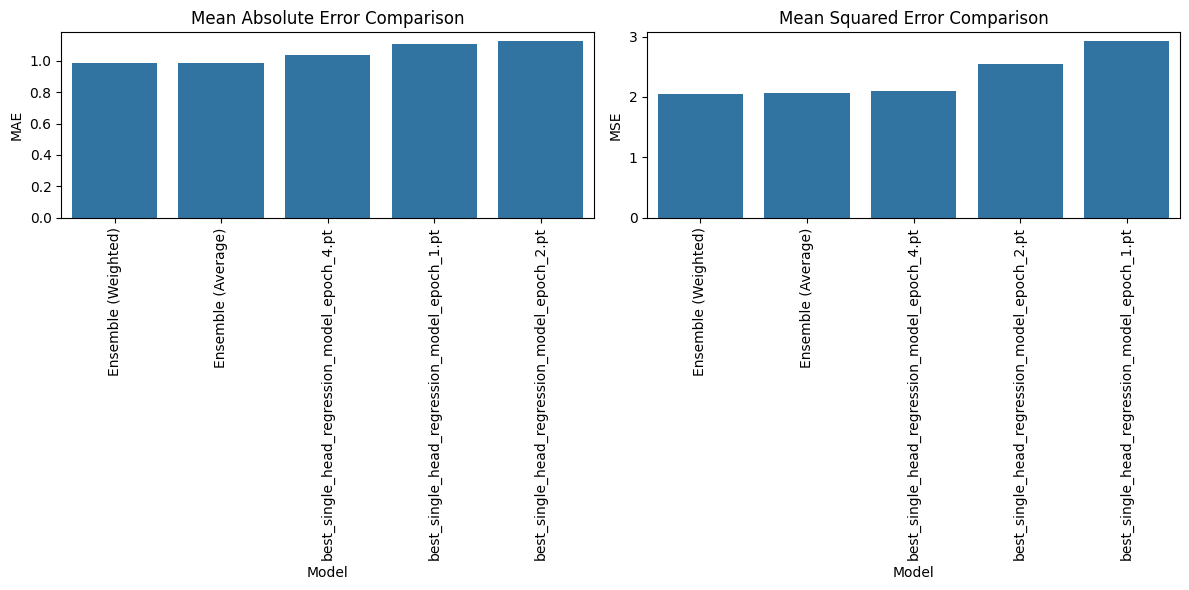

In [27]:
plt.figure(figsize=(12, 6))

# Plot MAE comparison
plt.subplot(1, 2, 1)
sns.barplot(x='Model', y='MAE', data=comparison_df.sort_values('MAE'))
plt.xticks(rotation=90)
plt.title('Mean Absolute Error Comparison')
plt.tight_layout()

# Plot MSE comparison
plt.subplot(1, 2, 2)
sns.barplot(x='Model', y='MSE', data=comparison_df.sort_values('MSE'))
plt.xticks(rotation=90)
plt.title('Mean Squared Error Comparison')
plt.tight_layout()

#plt.savefig('ensemble_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## Save Best Ensemble

In [28]:
# Save best ensemble info
best_ensemble = {
    'type': 'weighted' if weighted_mae < ensemble_mae else 'average',
    'models': [m['name'] for m in models],
    'weights': weights.tolist() if weighted_mae < ensemble_mae else None,
    'mae': min(weighted_mae, ensemble_mae),
    'mse': weighted_mse if weighted_mae < ensemble_mae else ensemble_mse,
    'predictions': weighted_ensemble_predictions.tolist() if weighted_mae < ensemble_mae else ensemble_predictions.tolist()
}

with open('best_ensemble_info.pkl', 'wb') as f:
    pickle.dump(best_ensemble, f)

print(f"Saved best ensemble configuration (type: {best_ensemble['type']})")

Saved best ensemble configuration (type: weighted)


In [ ]:
# Create a function to apply the ensemble to new data
def apply_ensemble(dataloader, models, weights=None):
    all_predictions = []
    
    # Get predictions from each model
    for model_info in models:
        model = model_info['model']
        model.eval()
        model_predictions = []
        
        with torch.no_grad():
            for batch in tqdm(dataloader, desc=f"Generating predictions with {model_info['name']}"):
                batch = {k: v.to(device) for k, v in batch.items()}
                preds = model(
                    input_ids=batch['input_ids'],
                    attention_mask=batch['attention_mask']
                )
                model_predictions.extend(preds.cpu().numpy())
        
        all_predictions.append(np.array(model_predictions))
    
    # Stack predictions into a matrix
    predictions_matrix = np.vstack(all_predictions)
    
    # Apply weights if provided, otherwise use simple average
    if weights is not None:
        ensemble_preds = np.zeros_like(all_predictions[0])
        for i, preds in enumerate(all_predictions):
            ensemble_preds += weights[i] * preds
    else:
        ensemble_preds = np.mean(predictions_matrix, axis=0)
    
    return ensemble_preds